In [4]:
image_path=r"C:\Users\thooy\Downloads\Evaluation_Set\1.png"

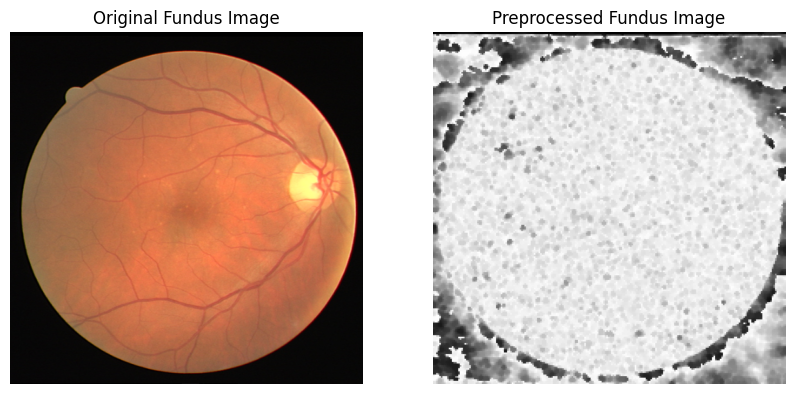

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import disk, dilation, erosion, closing
from skimage.filters import laplace
from skimage.restoration import denoise_nl_means

# Function to preprocess a single image
def preprocess_image(image_path):
    # Load image
    img = cv2.imread(image_path)
    
    # Check if the image was loaded correctly
    if img is None:
        print(f"Error: Could not load image at {image_path}. Please check the file path.")
        return None
    
    # Step 1: Green Channel Extraction
    green_channel = img[:, :, 1]
    
    # Step 2: Laplacian Sharpening
    laplacian = laplace(green_channel).astype(np.float32)
    green_channel_float = green_channel.astype(np.float32)
    laplacian_sharpened = cv2.addWeighted(green_channel_float, 1.5, laplacian, -0.5, 0)
    
    # Step 3: Matched Filtering (simulated using Gaussian filter)
    matched_filtered = cv2.GaussianBlur(laplacian_sharpened, (5, 5), 0)
    
    # Step 4: Non-local Means Filtering
    denoised = denoise_nl_means(matched_filtered, h=1.0, fast_mode=True)
    
    # Convert denoised result to 8-bit format
    denoised = (denoised * 255).astype(np.uint8)
    
    # Step 5: Dilation and Erosion
    dilated = dilation(denoised, disk(3))
    eroded = erosion(dilated, disk(3))
    
    # Step 6: Closing
    closed = closing(eroded, disk(3))
    
    # Resize for visualization (if needed)
    processed_img = cv2.resize(closed, (224, 224))
    return processed_img

# Load and preprocess a sample image
#sample_image_path = 'path/to/sample_fundus_image.jpg'  # Replace with the path to your test image
preprocessed_image = preprocess_image(image_path)

# Check if preprocessing was successful before displaying
if preprocessed_image is not None:
    # Display original and preprocessed images
    original_image = cv2.imread(image_path)
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image_rgb)
    plt.title("Original Fundus Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(preprocessed_image, cmap='gray')
    plt.title("Preprocessed Fundus Image")
    plt.axis("off")

    plt.show()


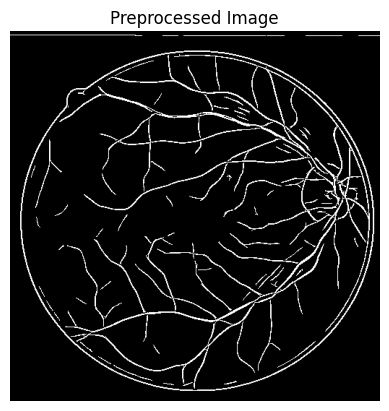

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function for CLAHE application
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

# Matched filter function
def matched_filter(image, kernel_sizes=[9, 15, 21], sigma=2, num_angles=24, wavelengths=[10, 15], gammas=[0.5, 1]):
    filtered_images = []
    for kernel_size in kernel_sizes:
        for angle in range(num_angles):
            theta = np.deg2rad(angle * 180 / num_angles)
            for wavelength in wavelengths:
                for gamma in gammas:
                    kernel = cv2.getGaborKernel((kernel_size, kernel_size), sigma, theta, wavelength, gamma, 0, ktype=cv2.CV_32F)
                    filtered_image = cv2.filter2D(image, cv2.CV_32F, kernel)
                    filtered_images.append(filtered_image)
    combined_image = np.max(np.array(filtered_images), axis=0)
    return combined_image

# Function to display the image
def plot_image(image, title="Image"):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Preprocess image function
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image {image_path}")
        return None

    # Step 1: Extract the green channel
    green_channel = image[:, :, 1]

    # Step 2: Apply Laplacian sharpening
    log_image = cv2.Laplacian(green_channel, cv2.CV_64F)
    log_image = np.uint8(255 * (log_image - np.min(log_image)) / (np.max(log_image) - np.min(log_image)))

    # Step 3: Apply CLAHE
    clahe = apply_clahe(log_image)

    # Step 4: Apply matched filter
    matched = matched_filter(clahe, num_angles=10, wavelengths=[10], gammas=[0.5, 1, 2])
    matched = cv2.normalize(matched, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Step 5: Apply Gaussian blur for unsharp masking
    blurred = cv2.GaussianBlur(matched, (7, 7), 10.0)
    unsharp_image = cv2.addWeighted(matched, 1.5, blurred, -0.5, 0)

    # Step 6: Apply Non-Local Means Filtering
    non_local_means_filtered = cv2.fastNlMeansDenoising(matched, None, h=3, templateWindowSize=3, searchWindowSize=50)

    # Step 7: Apply morphological closing
    kernel = np.ones((3, 3), np.uint8)
    closed_image = cv2.morphologyEx(non_local_means_filtered, cv2.MORPH_CLOSE, kernel)
    closed_image = cv2.bitwise_not(closed_image)

    # Step 8: Apply adaptive thresholding
    adaptive_thresh_mean = cv2.adaptiveThreshold(
        closed_image, 
        255, 
        cv2.ADAPTIVE_THRESH_MEAN_C, 
        cv2.THRESH_BINARY, 
        3, 
        2  
    )

    # Step 9: Invert the image for connected component analysis
    inverted = cv2.bitwise_not(adaptive_thresh_mean)
    num_labels, labels_im = cv2.connectedComponents(inverted)
    output_image = np.zeros_like(inverted)
    min_size = 15
    for label in range(1, num_labels):  
        component_size = np.sum(labels_im == label)
        if component_size >= min_size:
            output_image[labels_im == label] = 255

    return output_image

# Define the path to the image (change this to the actual image file path)
#image_path = r'C:\projects\ip\Data\train\image\your_image.jpg'  # Update with the correct path

# Preprocess and display the image
processed_image = preprocess_image(image_path)

if processed_image is not None:
    plot_image(processed_image, "Preprocessed Image")


In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical


In [8]:
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

def matched_filter(image, kernel_sizes=[9, 15, 21], sigma=2, num_angles=24, wavelengths=[10, 15], gammas=[0.5, 1]):
    filtered_images = []
    for kernel_size in kernel_sizes:
        for angle in range(num_angles):
            theta = np.deg2rad(angle * 180 / num_angles)
            for wavelength in wavelengths:
                for gamma in gammas:
                    kernel = cv2.getGaborKernel((kernel_size, kernel_size), sigma, theta, wavelength, gamma, 0, ktype=cv2.CV_32F)
                    filtered_image = cv2.filter2D(image, cv2.CV_32F, kernel)
                    filtered_images.append(filtered_image)
    combined_image = np.max(np.array(filtered_images), axis=0)
    return combined_image

def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image {image_path}")
        return None

    # Green channel extraction
    green_channel = image[:, :, 1]
    # Laplacian sharpening
    log_image = cv2.Laplacian(green_channel, cv2.CV_64F)
    log_image = np.uint8(255 * (log_image - np.min(log_image)) / (np.max(log_image) - np.min(log_image)))

    # CLAHE
    clahe = apply_clahe(log_image)
    
    # Matched filtering
    matched = matched_filter(clahe, num_angles=10, wavelengths=[10], gammas=[0.5, 1, 2])
    matched = cv2.normalize(matched, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    # Gaussian blur & unsharp masking
    blurred = cv2.GaussianBlur(matched, (7, 7), 10.0)
    unsharp_image = cv2.addWeighted(matched, 1.5, blurred, -0.5, 0)
    
    # Non-local means filtering
    non_local_means_filtered = cv2.fastNlMeansDenoising(matched, None, h=3, templateWindowSize=3, searchWindowSize=50)
    
    # Morphological closing
    kernel = np.ones((3, 3), np.uint8)
    closed_image = cv2.morphologyEx(non_local_means_filtered, cv2.MORPH_CLOSE, kernel)
    closed_image = cv2.bitwise_not(closed_image)
    
    # Adaptive thresholding
    adaptive_thresh_mean = cv2.adaptiveThreshold(closed_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 3, 2)
    
    # Invert the image and apply connected component analysis
    inverted = cv2.bitwise_not(adaptive_thresh_mean)
    num_labels, labels_im = cv2.connectedComponents(inverted)
    output_image = np.zeros_like(inverted)
    min_size = 15
    for label in range(1, num_labels):  
        component_size = np.sum(labels_im == label)
        if component_size >= min_size:
            output_image[labels_im == label] = 255
    return output_image


In [9]:
def load_images_and_labels(dataset_path):
    images = []
    labels = []
    label_dict = {'normal': 0, 'cataract': 1, 'glaucoma': 2, 'hypertension': 3, 'cataract': 4}  # Example

    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        
        if os.path.isdir(subfolder_path):
            for image_name in os.listdir(subfolder_path):
                image_path = os.path.join(subfolder_path, image_name)
                if image_path.endswith('.jpg') or image_path.endswith('.png'):
                    preprocessed_image = preprocess_image(image_path)
                    if preprocessed_image is not None:
                        images.append(preprocessed_image)
                        labels.append(label_dict[subfolder])  # Assuming subfolder names are the class labels

    return np.array(images), np.array(labels)


In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

# Define image preprocessing function
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image {image_path}")
        return None
    
    green_channel = image[:, :, 1]  # Green channel extraction
    log_image = cv2.Laplacian(green_channel, cv2.CV_64F)
    log_image = np.uint8(255 * (log_image - np.min(log_image)) / (np.max(log_image) - np.min(log_image)))
    
    clahe = apply_clahe(log_image)
    matched = matched_filter(clahe, num_angles=10, wavelengths=[10], gammas=[0.5, 1, 2])
    matched = cv2.normalize(matched, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    blurred = cv2.GaussianBlur(matched, (7, 7), 10.0)
    unsharp_image = cv2.addWeighted(matched, 1.5, blurred, -0.5, 0)
    
    non_local_means_filtered = cv2.fastNlMeansDenoising(matched, None, h=3, templateWindowSize=3, searchWindowSize=50)
    
    kernel = np.ones((3, 3), np.uint8)  
    closed_image = cv2.morphologyEx(non_local_means_filtered, cv2.MORPH_CLOSE, kernel)
    closed_image = cv2.bitwise_not(closed_image)
    
    adaptive_thresh_mean = cv2.adaptiveThreshold(
        closed_image, 
        255, 
        cv2.ADAPTIVE_THRESH_MEAN_C, 
        cv2.THRESH_BINARY, 
        3, 
        2  
    )
    
    inverted = cv2.bitwise_not(adaptive_thresh_mean)
    num_labels, labels_im = cv2.connectedComponents(inverted)
    output_image = np.zeros_like(inverted)
    
    min_size = 15
    for label in range(1, num_labels):  
        component_size = np.sum(labels_im == label)
        if component_size >= min_size:
            output_image[labels_im == label] = 255 
    
    return output_image

# Load and preprocess dataset
dataset_dir = r"C:\harish\ssn\sem 5\Image Processing\assignment\archive (1)\datasets"
categories = ['ageDegeneration', 'cataract', 'diabetes', 'glaucoma', 'hypertension', 'myopia', 'normal', 'others']

images = []
labels = []

for label, category in enumerate(categories):
    category_path = os.path.join(dataset_dir, category)
    for filename in os.listdir(category_path):
        image_path = os.path.join(category_path, filename)
        preprocessed_image = preprocess_image(image_path)
        if preprocessed_image is not None:
            images.append(preprocessed_image)
            labels.append(label)

# Convert images and labels to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the images
images = images.astype('float32') / 255.0

# Convert labels to one-hot encoding
labels = to_categorical(labels, num_classes=len(categories))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Print the shapes of the train and test sets
print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")




FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\harish\\ssn\\sem 5\\Image Processing\\assignment\\archive (1)\\datasets\\ageDegeneration'

In [17]:
# Load the dataset
dataset_path = r"C:\harish\ssn\sem 5\Image Processing\assignment\archive (1)\datasets"  # Replace with actual dataset path
X, y = load_images_and_labels(dataset_path)

# Resize all images to the same size
X_resized = np.array([cv2.resize(img, (128, 128)) for img in X])  # Resize to 128x128
X_resized = X_resized.astype('float32') / 255.0  # Normalize pixel values to [0, 1]

# Convert labels to one-hot encoding
y_one_hot = to_categorical(y, num_classes=5)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resized, y_one_hot, test_size=0.2, random_state=42)


KeyError: 'ageDegeneration'

In [ ]:
# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # 5 classes (healthy, diabetic_retinopathy, glaucoma, macular_degeneration, cataract)
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Function for CLAHE (Contrast Limited Adaptive Histogram Equalization)
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

# Matched filter function (already defined in previous steps)
def matched_filter(image, kernel_sizes=[9, 15, 21], sigma=2, num_angles=24, wavelengths=[10, 15], gammas=[0.5, 1]):
    filtered_images = []
    for kernel_size in kernel_sizes:
        for angle in range(num_angles):
            # Create a line filter at different angles
            theta = np.deg2rad(angle * 180 / num_angles)
            for wavelength in wavelengths:
                for gamma in gammas:
                    # Create the Gabor kernel
                    kernel = cv2.getGaborKernel((kernel_size, kernel_size), sigma, theta, wavelength, gamma, 0, ktype=cv2.CV_32F)
                    # Apply the filter to the image
                    filtered_image = cv2.filter2D(image, cv2.CV_32F, kernel)
                    filtered_images.append(filtered_image)
    
    # Combine filtered images by taking the maximum value at each pixel
    combined_image = np.max(np.array(filtered_images), axis=0)
    return combined_image

# Preprocessing function
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image {image_path}")
        return None
    
    green_channel = image[:, :, 1]  # Green channel extraction
    log_image = cv2.Laplacian(green_channel, cv2.CV_64F)
    log_image = np.uint8(255 * (log_image - np.min(log_image)) / (np.max(log_image) - np.min(log_image)))
    
    clahe = apply_clahe(log_image)
    matched = matched_filter(clahe, num_angles=10, wavelengths=[10], gammas=[0.5, 1, 2])
    matched = cv2.normalize(matched, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    blurred = cv2.GaussianBlur(matched, (7, 7), 10.0)
    unsharp_image = cv2.addWeighted(matched, 1.5, blurred, -0.5, 0)
    
    non_local_means_filtered = cv2.fastNlMeansDenoising(matched, None, h=3, templateWindowSize=3, searchWindowSize=50)
    
    kernel = np.ones((3, 3), np.uint8)  
    closed_image = cv2.morphologyEx(non_local_means_filtered, cv2.MORPH_CLOSE, kernel)
    closed_image = cv2.bitwise_not(closed_image)
    
    adaptive_thresh_mean = cv2.adaptiveThreshold(
        closed_image, 
        255, 
        cv2.ADAPTIVE_THRESH_MEAN_C, 
        cv2.THRESH_BINARY, 
        3, 
        2  
    )
    
    inverted = cv2.bitwise_not(adaptive_thresh_mean)
    num_labels, labels_im = cv2.connectedComponents(inverted)
    output_image = np.zeros_like(inverted)
    
    min_size = 15
    for label in range(1, num_labels):  
        component_size = np.sum(labels_im == label)
        if component_size >= min_size:
            output_image[labels_im == label] = 255 
    
    return output_image

# Load and preprocess dataset
dataset_dir = r"C:\harish\ssn\sem 5\Image Processing\assignment\archive (1)\datasets"
categories = ['ageDegeneration', 'cataract', 'diabetes', 'glaucoma', 'hypertension', 'myopia', 'normal', 'others']

images = []
labels = []

for label, category in enumerate(categories):
    category_path = os.path.join(dataset_dir, category)
    for filename in os.listdir(category_path):
        image_path = os.path.join(category_path, filename)
        preprocessed_image = preprocess_image(image_path)
        if preprocessed_image is not None:
            images.append(preprocessed_image)
            labels.append(label)

# Convert images and labels to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the images
images = images.astype('float32') / 255.0

# Convert labels to one-hot encoding
labels = to_categorical(labels, num_classes=len(categories))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Reshape the images for CNN (adding channel dimension)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Build the CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))  # Output layer with number of classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Plot training history


KeyboardInterrupt: 

C:\Users\haris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 390ms/step - accuracy: 0.1187 - loss: 2.6766 - val_accuracy: 0.1875 - val_loss: 2.0417
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 319ms/step - accuracy: 0.2021 - loss: 2.0480 - val_accuracy: 0.2500 - val_loss: 2.0722
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step - accuracy: 0.3104 - loss: 2.0148 - val_accuracy: 0.3438 - val_loss: 2.0624
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step - accuracy: 0.3281 - loss: 1.9057 - val_accuracy: 0.2812 - val_loss: 2.0396
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 326ms/step - accuracy: 0.3781 - loss: 1.7199 - val_accuracy: 0.3438 - val_loss: 1.9183
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step - accuracy: 0.5510 - loss: 1.5275 - val_accuracy: 0.3125 - val_loss: 1.9034
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step - accuracy: 0.6198 - loss: 1.1492 - val_accuracy: 0.3125 - val_loss: 1.9645
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step - accuracy: 0.7990 - loss: 0.7244 - val_accuracy: 0.2812 - val_loss:

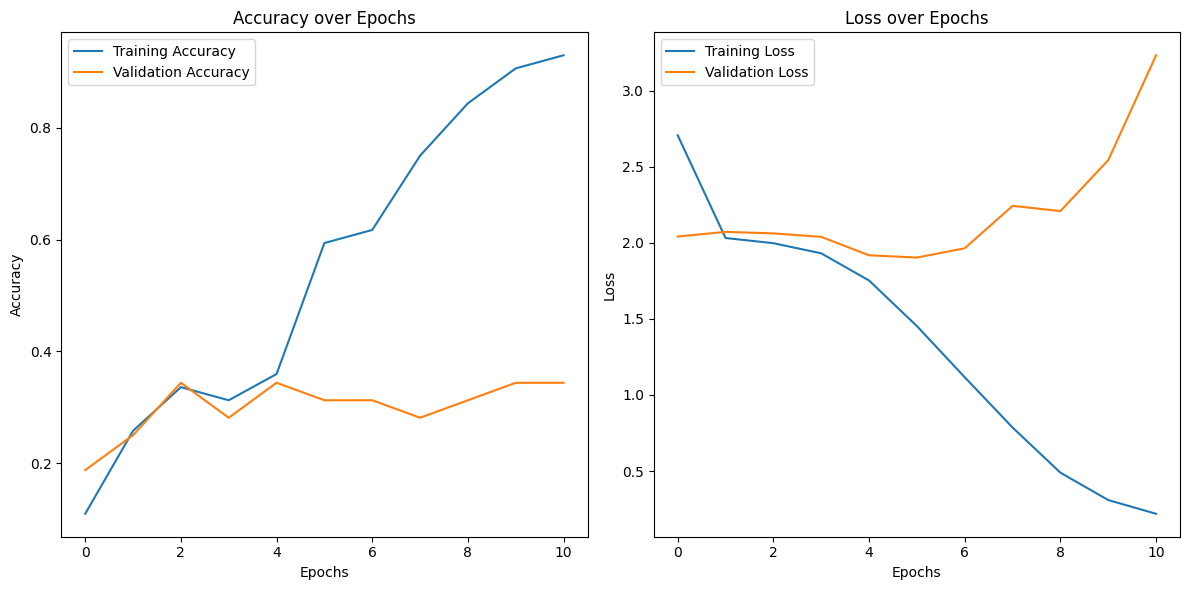

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


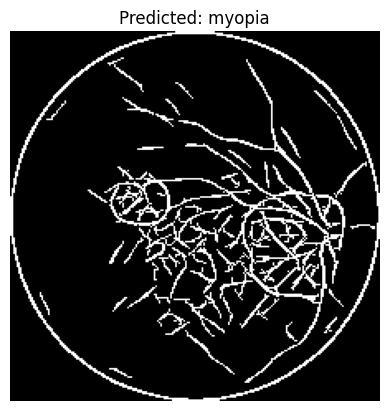

In [20]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Function for CLAHE (Contrast Limited Adaptive Histogram Equalization)
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

# Matched filter function (already defined in previous steps)
def matched_filter(image, kernel_sizes=[9, 15, 21], sigma=2, num_angles=24, wavelengths=[10, 15], gammas=[0.5, 1]):
    filtered_images = []
    for kernel_size in kernel_sizes:
        for angle in range(num_angles):
            # Create a line filter at different angles
            theta = np.deg2rad(angle * 180 / num_angles)
            for wavelength in wavelengths:
                for gamma in gammas:
                    # Create the Gabor kernel
                    kernel = cv2.getGaborKernel((kernel_size, kernel_size), sigma, theta, wavelength, gamma, 0, ktype=cv2.CV_32F)
                    # Apply the filter to the image
                    filtered_image = cv2.filter2D(image, cv2.CV_32F, kernel)
                    filtered_images.append(filtered_image)
    
    # Combine filtered images by taking the maximum value at each pixel
    combined_image = np.max(np.array(filtered_images), axis=0)
    return combined_image

# Preprocessing function
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image {image_path}")
        return None
    
    green_channel = image[:, :, 1]  # Green channel extraction
    log_image = cv2.Laplacian(green_channel, cv2.CV_64F)
    log_image = np.uint8(255 * (log_image - np.min(log_image)) / (np.max(log_image) - np.min(log_image)))
    
    clahe = apply_clahe(log_image)
    matched = matched_filter(clahe, num_angles=10, wavelengths=[10], gammas=[0.5, 1, 2])
    matched = cv2.normalize(matched, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    blurred = cv2.GaussianBlur(matched, (7, 7), 10.0)
    unsharp_image = cv2.addWeighted(matched, 1.5, blurred, -0.5, 0)
    
    non_local_means_filtered = cv2.fastNlMeansDenoising(matched, None, h=3, templateWindowSize=3, searchWindowSize=50)
    
    kernel = np.ones((3, 3), np.uint8)  
    closed_image = cv2.morphologyEx(non_local_means_filtered, cv2.MORPH_CLOSE, kernel)
    closed_image = cv2.bitwise_not(closed_image)
    
    adaptive_thresh_mean = cv2.adaptiveThreshold(
        closed_image, 
        255, 
        cv2.ADAPTIVE_THRESH_MEAN_C, 
        cv2.THRESH_BINARY, 
        3, 
        2  
    )
    
    inverted = cv2.bitwise_not(adaptive_thresh_mean)
    num_labels, labels_im = cv2.connectedComponents(inverted)
    output_image = np.zeros_like(inverted)
    
    min_size = 15
    for label in range(1, num_labels):  
        component_size = np.sum(labels_im == label)
        if component_size >= min_size:
            output_image[labels_im == label] = 255 
    
    return output_image

# Load and preprocess dataset (trimming the dataset by selecting a small subset)
dataset_dir = r"C:\harish\ssn\sem 5\Image Processing\assignment\archive (1)\datasets"
categories = ['ageDegeneration', 'cataract', 'diabetes', 'glaucoma', 'hypertension', 'myopia', 'normal', 'others']

images = []
labels = []

# Number of images to sample per category
num_images_per_category = 20  # Adjust this to reduce the dataset size

for label, category in enumerate(categories):
    category_path = os.path.join(dataset_dir, category)
    image_files = os.listdir(category_path)[:num_images_per_category]  # Select only a subset of images
    for filename in image_files:
        image_path = os.path.join(category_path, filename)
        preprocessed_image = preprocess_image(image_path)
        if preprocessed_image is not None:
            images.append(preprocessed_image)
            labels.append(label)

# Convert images and labels to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Normalize the images
images = images.astype('float32') / 255.0

# Convert labels to one-hot encoding
labels = to_categorical(labels, num_classes=len(categories))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Reshape the images for CNN (adding channel dimension)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Build the CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(categories), activation='softmax'))  # Output layer with number of classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Plot training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Show an example of a test image and its predicted class
predicted_class = model.predict(X_test[0].reshape(1, X_test.shape[1], X_test.shape[2], 1))
predicted_class_label = categories[np.argmax(predicted_class)]

plt.imshow(X_test[0].reshape(X_test.shape[1], X_test.shape[2]), cmap='gray')
plt.title(f"Predicted: {predicted_class_label}")
plt.axis('off')
plt.show()
